In [323]:
import pandas as pd 
import os 

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import seaborn as sns

from datasets import load_dataset
import numpy as np

In [3]:
pwd

'/home/al2644/research/codebase/reasoning/perturb-r/notebook'

In [5]:
cd /home/al2644/research/codebase/reasoning/perturb-r

/home/al2644/research/codebase/reasoning/perturb-r


# Utils

In [21]:
def chunking(model_response, granularity=20):
    """Split thinking into chunks of approximately equal size."""
    # Step 1: merge small chunks
    thinking = model_response.split('</think>')[0]
    chunks = thinking.split('\n\n')
    masks = [len(chunk.split()) > granularity for chunk in chunks]

    merged, buffer = [], []
    for c, m in zip(chunks, masks):
        if not m:
            buffer.append(c)
        else:
            if buffer:
                merged.append('\n\n'.join(buffer))  # Use '\n\n' to maintain paragraph structure
                buffer.clear()
            merged.append(c)
    if buffer:
        merged.append('\n\n'.join(buffer))

    # Step 2: merge small chunks to big chunks
    super_chunks, current = [], None
    for c in merged:
        if len(c.split()) > granularity:
            if current is not None:
                super_chunks.append(current)
            current = c
        else:
            if current is None:
                # no big chunk yet
                current = c
            else:
                current += '\n\n' + c  # Use '\n\n' to maintain paragraph structure

    if current is not None:
        super_chunks.append(current)

    return super_chunks

# Reasoning Results

In [324]:
root = "./results/math-500/reasoning/"
for fname in os.listdir(root):
    if 'correct' not in fname:
        print(fname)
        df = pd.read_pickle(os.path.join(root, fname))
        print(f"Accuracy: {df['correct'].mean()}")

R1-Distill-Qwen-1.5B.pickle
Accuracy: 0.8413333333333334
R1-Distill-Qwen-7B.pickle
Accuracy: 0.9213333333333333
R1-Distill-Qwen-14B.pickle
Accuracy: 0.939
R1-Distill-Qwen-32B.pickle
Accuracy: 0.9473333333333334


In [340]:
df = pd.read_pickle(os.path.join(root, "R1-Distill-Qwen-14B.pickle"))

<Axes: xlabel='correct', ylabel='Count'>

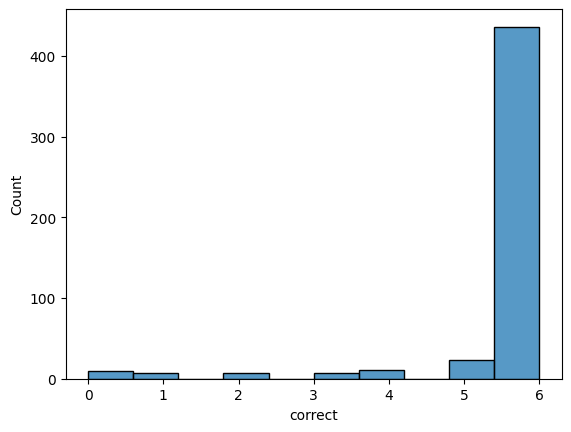

In [341]:
sns.histplot(df.groupby(["unique_id"])["correct"].sum().to_frame()["correct"])

# Digit Corruption Results

### Corrupt answer digit backwards

In [203]:
from reward_score.math import last_boxed_only_string, remove_boxed

def if_answer (response):
    try:
        math_answer = remove_boxed(last_boxed_only_string(response))
        return True
    except:
        return False
    
def digit_corrupt_analysis (df: pd.DataFrame, cutoffs: list, col: str, stats: str):
    cutoffs.sort()
    final_index = ["< " + str(cutoff) for cutoff in cutoffs] + ['> ' + str(cutoffs[-1])]
    
    def group(col, cutoffs = cutoffs):        
        for cutoff in cutoffs:
            if col < cutoff:
                return f"< {cutoff}"

        return f"> {cutoffs[-1]}"

    df["answer_rate"] = df["post_corruption_response"].apply(if_answer)
    df['group'] = df[col].apply(group)
    
    dist = df['group'].value_counts().loc[final_index]
    perf = df.groupby('group')[stats].mean().loc[final_index]
    answer_rate = df.groupby('group')["answer_rate"].mean().loc[final_index]
    
    return {"num corrupted digits": dist, 
            "answer rate": answer_rate,
            "accuracy": perf
           }

In [233]:
root = "./results/hendrycks_math/sample200/digit_corruption/"
cutoffs = [15, 45]
[fname for fname in os.listdir(root) if "answer_digit" in fname]

['R1-Distill-Qwen-1.5B_type=answer_digit.pickle',
 'R1-Distill-Qwen-7B_type=answer_digit.pickle',
 'R1-Distill-Qwen-14B_type=answer_digit.pickle',
 'QwQ-32B_type=answer_digit.pickle',
 'R1-Distill-Qwen-32B_type=answer_digit.pickle',
 'AM-Distill-Qwen-32B_type=answer_digit.pickle',
 'Qwen3-1.7B_type=answer_digit.pickle',
 'Qwen3-4B_type=answer_digit.pickle',
 'Qwen3-8B_type=answer_digit.pickle',
 'R1-Distill-Qwen3-8B_type=answer_digit.pickle',
 'Qwen3-30B-A3B_type=answer_digit.pickle',
 'Qwen3-32B_type=answer_digit.pickle',
 'R1-Distill-Llama-8B_type=answer_digit.pickle']

In [231]:
df = pd.read_pickle(os.path.join(root, 'Qwen3-32B_type=answer_digit.pickle'))
print("accuracy: \n", group_analysis(df, cutoffs, "num_corrupted", "still_correct"))

accuracy: 
 {'num corrupted digits': group
< 15    294
< 45    462
> 45    546
Name: count, dtype: int64, 'answer rate': group
< 15    1.0
< 45    1.0
> 45    1.0
Name: answer_rate, dtype: float64, 'accuracy': group
< 15    0.911565
< 45    0.800866
> 45    0.688645
Name: still_correct, dtype: float64}


### Corrupt all digits forwards

In [234]:
root = "./results/hendrycks_math/sample200/digit_corruption/"
cutoffs = [15, 45]
[fname for fname in os.listdir(root) if "midway" in fname]

['R1-Distill-Qwen-1.5B_type=midway.pickle',
 'R1-Distill-Qwen-7B_type=midway.pickle',
 'R1-Distill-Qwen-14B_type=midway.pickle',
 'QwQ-32B_type=midway.pickle',
 'R1-Distill-Qwen-32B_type=midway.pickle',
 'AM-Distill-Qwen-32B_type=midway.pickle',
 'Qwen3-1.7B_type=midway.pickle',
 'Qwen3-4B_type=midway.pickle',
 'Qwen3-8B_type=midway.pickle',
 'R1-Distill-Qwen3-8B_type=midway.pickle',
 'Qwen3-30B-A3B_type=midway.pickle',
 'Qwen3-32B_type=midway.pickle',
 'R1-Distill-Llama-8B_type=midway.pickle']

In [245]:
df = pd.read_pickle(os.path.join(root, 'Qwen3-32B_type=midway.pickle'))
print("accuracy: \n", group_analysis(df, cutoffs, "frequency", "still_correct"))

accuracy: 
 {'num corrupted digits': group
< 15    202
< 45    355
> 45    765
Name: count, dtype: int64, 'answer rate': group
< 15    0.990099
< 45    0.954930
> 45    0.958170
Name: answer_rate, dtype: float64, 'accuracy': group
< 15    0.945545
< 45    0.892958
> 45    0.819608
Name: still_correct, dtype: float64}


# Distraction

## Full distraction

In [303]:
from reward_score.math import last_boxed_only_string, remove_boxed

def if_answer (response):
    try:
        math_answer = remove_boxed(last_boxed_only_string(response))
        return True
    except:
        return False
    
def group_analysis (df: pd.DataFrame, cutoffs: list, col: str, stats: str):
    cutoffs.sort()
    final_index = ["< " + str(cutoff) for cutoff in cutoffs] + ['> ' + str(cutoffs[-1])]
    
    def group(col, cutoffs = cutoffs):        
        for cutoff in cutoffs:
            if col < cutoff:
                return f"< {cutoff}"

        return f"> {cutoffs[-1]}"

    df["answer_rate"] = df["post_distraction_response"].apply(if_answer)
    df['token_count_groups'] = df[col].apply(group)
    
    token_dist = df['token_count_groups'].value_counts().loc[final_index]
    perf = df.groupby('token_count_groups')[stats].mean().loc[final_index]
    answer_rate = df.groupby('token_count_groups')["answer_rate"].mean().loc[final_index]
    
    return {"corrupting token counts": token_dist, 
            "answer rate": answer_rate,
            "accuracy": perf
           }

def token_weighted_backtrack_rate (df: pd.DataFrame):
    original_correct = (df["original_correct"] * df['num_distract_tokens']).mean()
    distractor_correct = (df["distractor_correct"] * df['num_distract_tokens']).mean()
    
    return 

In [304]:
root = './results/hendrycks_math/sample200/distract_thinking'
cutoffs = [500, 1500]
[fname for fname in os.listdir(root) if "inject_user_prompt"  in fname]

['R1-Distill-Qwen-1.5B_inject_user_prompt.pickle',
 'R1-Distill-Qwen-7B_inject_user_prompt.pickle',
 'R1-Distill-Qwen-14B_inject_user_prompt.pickle',
 'R1-Distill-Qwen-32B_inject_user_prompt.pickle',
 'AM-Distill-Qwen-32B_inject_user_prompt.pickle',
 'QwQ-32B_inject_user_prompt.pickle',
 'Qwen3-1.7B_inject_user_prompt.pickle',
 'Qwen3-4B_inject_user_prompt.pickle',
 'Qwen3-8B_inject_user_prompt.pickle',
 'R1-Distill-Qwen3-8B_inject_user_prompt.pickle',
 'Qwen3-30B-A3B_inject_user_prompt.pickle',
 'Qwen3-32B_inject_user_prompt.pickle',
 'R1-Distill-Llama-8B_inject_user_prompt.pickle']

In [322]:
df = pd.read_pickle(os.path.join(root, 'Qwen3-32B_inject_user_prompt.pickle'))

print("accuracy according to original solution: \n", group_analysis(df, cutoffs, "num_distract_tokens", "original_correct"))
print('*' * 50, '\n\n')
print("accuracy according to distractor solution: \n", group_analysis(df, cutoffs, "num_distract_tokens", "distractor_correct"))

accuracy according to original solution: 
 {'corrupting token counts': token_count_groups
< 500     194
< 1500    220
> 1500    486
Name: count, dtype: int64, 'answer rate': token_count_groups
< 500     0.994845
< 1500    0.995455
> 1500    1.000000
Name: answer_rate, dtype: float64, 'accuracy': token_count_groups
< 500     0.412371
< 1500    0.522727
> 1500    0.537037
Name: original_correct, dtype: float64}
************************************************** 


accuracy according to distractor solution: 
 {'corrupting token counts': token_count_groups
< 500     194
< 1500    220
> 1500    486
Name: count, dtype: int64, 'answer rate': token_count_groups
< 500     0.994845
< 1500    0.995455
> 1500    1.000000
Name: answer_rate, dtype: float64, 'accuracy': token_count_groups
< 500     0.577320
< 1500    0.472727
> 1500    0.452675
Name: distractor_correct, dtype: float64}


In [282]:
example = df.sample(n=1).iloc[0]
print("Original Correct?: ", example["original_correct"], "Distractor Correct?: ", example["distractor_correct"])
print(example["problem"], "\n\n", "=" * 100)
print(example["distract_reasoning"], "\n\n", "=" * 100)
print(example["post_distraction_response"])

Original Correct?:  0.0 Distractor Correct?:  1.0
<｜begin▁of▁sentence｜><｜User｜>A regular tetrahedron is a pyramid with four faces, each of which is an equilateral triangle.

Let $ABCD$ be a regular tetrahedron and let $P$ be the unique point equidistant from points $A,B,C,D$. Extend $\overrightarrow{AP}$ to hit face $BCD$ at point $Q$. What is the ratio $PQ/AQ$ ?<｜Assistant｜><think>
 

Alright, so I need to find the midpoint of the line segment connecting points P(5,3) and Q(-3,6). Hmm, okay, midpoints. I remember that the midpoint formula is something like taking the average of the x-coordinates and the average of the y-coordinates of the two points. Let me try to recall the exact formula.

I think it's ( (x1 + x2)/2 , (y1 + y2)/2 ). Yeah, that seems right. So, for points P(x1, y1) and Q(x2, y2), the midpoint M is given by M = ( (x1 + x2)/2 , (y1 + y2)/2 ). Okay, so let's plug in the values from points P and Q.

Point P is (5,3), so x1 is 5 and y1 is 3. Point Q is (-3,6), so x2 is -3 

In [256]:
print("Original Solution: ", example["solution"], "\n\n", "=" * 100)
print("Distractor Solution: ", example["distract_solution"])

Original Solution:  Let $r$ and $s$ be the $x$-coordinates of the two points of tangency.  As such, they will be double roots of the polynomial
\[(x^4 + ax^3 + x^2 + bx + 1) - x^2 = x^4 + ax^3 + bx + 1.\]Hence,
\begin{align*}
x^4 + ax^3 + bx + 1 &= (x - r)^2 (x - s)^2 \\
&= (x^2 - 2rx + r^2)(x^2 - 2sx + s^2) \\
&= x^4 - (2r + 2s) x^3 + (r^2 + 4rs + s^2) x^2 - (2r^2 s + 2rs^2) x + r^2 s^2.
\end{align*}Matching coefficients, we get
\begin{align*}
r^2 + 4rs + s^2 &= 0, \\
r^2 s^2 &= 1.
\end{align*}From $r^2 s^2 = 1,$ either $rs = 1$ or $rs = -1.$  But $4rs = -(r^2 + s^2)$ is nonpositive, so $rs = -1.$  Then
\[r^2 + s^2 = 4.\]Hence, $(r - s)^2 = r^2 - 2rs + s^2 = 6,$ so $|r - s| = \boxed{\sqrt{6}}.$ 

Distractor Solution:  The GCD of 840, 960, and 1200 is 120. Since 120 has 16 positive divisors, 840, 960, and 1200 have $\boxed{16}$ common positive divisors.


# Midway distraction

### Todo:
1. The distraction at start is a special case of midway distraction
2. refractor the code to include both

In [180]:
root = './results/hendrycks_math/sample200/distract_thinking'
cutoffs = [.5, 1.0]
[fname for fname in os.listdir(root) if "midway" in fname]

['R1-Distill-Qwen-1.5B_midway.pickle',
 'R1-Distill-Qwen-7B_midway.pickle',
 'R1-Distill-Qwen-14B_midway.pickle',
 'R1-Distill-Llama-8B_midway.pickle',
 'QwQ-32B_midway.pickle',
 'Qwen3-1.7B_midway.pickle',
 'Qwen3-4B_midway.pickle',
 'Qwen3-8B_midway.pickle',
 'R1-Distill-Qwen3-8B_midway.pickle']

In [260]:
df = pd.read_pickle(os.path.join(root, "QwQ-32B_midway.pickle"))
df["original/distract ratio"] = df["num_original_reasoning_prefix_tokens"] / df["num_distract_tokens"]
print("accuracy according to original solution: \n", group_analysis(df, cutoffs, "original/distract ratio", "original_correct"))
print('*' * 50, '\n\n')
print("accuracy according to distractor solution: \n", group_analysis(df, cutoffs, "original/distract ratio", "distractor_correct"))


KeyError: "['< 1500', '> 1500'] not in index"

In [189]:
print(df["post_distraction_response"][100])

 

To find the extrema, we can take the derivative of f(x) and set it equal to zero. Let me compute f'(x):

f'(x) = derivative of arctan(x) + (1/2) derivative of arcsin(x).

The derivative of arctan(x) is 1/(1 + x²). 

The derivative of arcsin(x) is 1 / sqrt(1 - x²), so (1/2) times that is 1/(2 sqrt(1 - x²)).

Therefore:

f'(x) = 1/(1 + x²) + 1/(2 sqrt(1 - x²)).

Wait, but hold on. The problem is asking for the range of this function. Hmm, but maybe instead of calculus, I can find some substitution or identity that can help here? Let me think.

Alternatively, perhaps using calculus is the way to go. Let me proceed with calculus.

First, let's note that f(x) is defined on [-1, 1]. Let's compute f at the endpoints first:

At x = 1:

arctan(1) = π/4,

arcsin(1) = π/2,

so f(1) = π/4 + (1/2)(π/2) = π/4 + π/4 = π/2.

At x = -1:

arctan(-1) = -π/4,

arcsin(-1) = -π/2,

so f(-1) = -π/4 + (1/2)(-π/2) = -π/4 - π/4 = -π/2.

Hmm, interesting. So at the endpoints, we get π/2 and -π/2. But since f(

In [267]:
df["problem"][0]

'<|im_start|>user\nA target consists of four concentric circles with radii 4 inches, 6 inches, 8 inches and 10 inches as shown. Given that a dart is thrown that hits the target at a random point, what is the probability that it hits a shaded region? Express your answer as a common fraction.\n\n[asy]size(100); import graph; fill(Circle((0,0),5),gray(.6));\n\nclip(Circle((0,0),2) ^^ Circle((0,0),3) ^^ Circle((0,0),4),fillrule(1));\ndraw(Circle((0,0),2) ^^ Circle((0,0),3) ^^ Circle((0,0),4) ^^ Circle((0,0),5));[/asy]<|im_end|>\n<|im_start|>assistant\n<think>\n'

In [269]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/QwQ-32B")

In [191]:
print(df["distract_reasoning"][100])

Okay, so I have this problem here: The parabola y = x² is tangent to the graph of y = x⁴ + a x³ + x² + b x + 1 at two points. I need to find the positive difference between the x-coordinates of these points of tangency. Hmm, okay. Let's see. 

First, since the two graphs are tangent to each other at two points, that means they not only intersect at those points but also share a common tangent line there. So, at the points of tangency, both the functions and their derivatives must be equal. That gives me a system of equations to work with. 

Let me denote the points of tangency as (s, s²) and (t, t²). Since these points lie on both curves, substituting into both equations should satisfy them. 

So for each point, say (s, s²), substituting into the quartic equation gives:

s² = s⁴ + a s³ + s² + b s + 1.

Wait, if I subtract s² from both sides, that cancels out the s² terms. So we get:

0 = s⁴ + a s³ + 0 s² + b s + 1.

Hmm, so that simplifies to s⁴ + a s³ + b s + 1 = 0.

Similarly, for th

In [295]:
df["problem"]

0      <|im_start|>user\nWhat is the sum of all the p...
1      <|im_start|>user\nWhat is the sum of all the p...
2      <|im_start|>user\nWhat is the sum of all the p...
3      <|im_start|>user\nWhat is the sum of all the p...
4      <|im_start|>user\nWhat is the sum of all the p...
                             ...                        
915    <|im_start|>user\nA palindrome is a number tha...
916    <|im_start|>user\nA palindrome is a number tha...
917    <|im_start|>user\nA palindrome is a number tha...
918    <|im_start|>user\nA palindrome is a number tha...
919    <|im_start|>user\nA palindrome is a number tha...
Name: problem, Length: 920, dtype: object